<a href="https://colab.research.google.com/github/setl1n/NUSRightShipHackathon2024/blob/main/rightship_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load imports
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load data from csv
folder_path = '*omitted*'
os.chdir(folder_path)
subfolder_path = 'vessel_movements/vessel_movements_PPT.csv'

# Convert vessel movements to a dataframe
df = pd.read_csv(os.path.join(folder_path, subfolder_path))
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822599 entries, 0 to 2822598
Data columns (total 32 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   imo                    int64  
 1   mmsi                   int64  
 2   vessel_id              int64  
 3   vessel_name            object 
 4   date_of_build          object 
 5   vessel_type            object 
 6   group                  object 
 7   timestamp              object 
 8   date_only              object 
 9   lon                    float64
 10  lat                    float64
 11  nav_stat               int64  
 12  speed                  float64
 13  course                 float64
 14  heading                float64
 15  fuel_category          int64  
 16  main_engine_fuel_type  object 
 17  aux_engine_fuel_type   object 
 18  engine_type            object 
 19  berth                  object 
 20  port_name              object 
 21  coverage               object 
 22  anchorage         

##**Data Dictionary**
| Column                 | Type    | Description                                                    |
|------------------------|---------|----------------------------------------------------------------|
| imo                    | int     | Vessel unique International Maritime Organization number      |
| mmsi                   | int     | Maritime Mobile Service Identity                               |
| vessel_id              | int     | ID of vessel                                                   |
| vessel_name            | string  | Name of the vessel                                             |
| date_of_build          | date    | Date when the vessel was built                                 |
| vessel_type            | string  | Type of vessel                                                 |
| group                  | string  | Vessel group                                                   |
| timestamp              | timestamp | Timestamp of the position update                               |
| date_only              | date    | Timestamp with time removed                                    |
| lon                    | float   | Geographical position – longitude (°)                          |
| lat                    | float   | Geographical position – latitude (°)                           |
| nav_stat               | int     | Navigational Status in an AIS message                          |
| speed                  | float   | Vessel speed (knots)                                           |
| course                 | float   | Vessel course                                                  |
| heading                | int     | Vessel directional heading (°)                                 |
| fuel_category          | int     | Category of the fuel used by the vessel                        |
| main_engine_fuel_type  | string  | Fuel type used by the main engine                              |
| aux_engine_fuel_type   | string  | Fuel type used by the auxiliary engine                         |
| engine_type            | string  | Category of the engine used by the vessel                      |
| berth                  | string  | Name of berth where the AIS point was located                  |
| port_name              | string  | Name of port where the AIS point was located                   |
| coverage               | string  | Port limit where the AIS point was located                     |
| anchorage              | string  | Anchorage polygon where the AIS point was located              |
| terminal               | string  | Terminal polygon where the AIS point was located               |
| maneuvering_zone       | string  | Maneuvering Zone where the AIS point was located               |
| p                      | int     | Power for propulsion engines (kilowatts[kW])                   |
| vref                   | float   | Reference speed                                                |
| sfc_me                 | float   | Main engine SFC                                                |
| sfc_ae                 | float   | Aux engine SFC                                                 |
| sfc_ab                 | float   | Auxiliary Boiler SFC                                           |
| ael                    | float   | Auxiliary engine load                                          |
| abl                    | float   | Auxiliary boiler load                                          |


In [3]:
# Fill 'null' speed values with 0
df['speed'].fillna(0, inplace=True)
# Find number of unique vessels (one of the deliverables)
unique_vessels = df['vessel_id'].nunique()
print(f"Number of unique vessels: {unique_vessels}")

Number of unique vessels: 2778


<div class="markdown"><h5>Step 1: Determine the operating mode of the vessel at each AIS data point</h5>
<p>GPS Speed provides movement activity which can be used to categorize vessels as either moving or stationary. </p>
<p>There are four operating modes:</p>
<ul>
<li>Transit: If speed &gt; 1 OR navigational status = 0, 3, 4, 8, 11, 12 (considered 'moving' statuses) and it's OUTSIDE the maneuvering zone but inside the bigger port fence.</li>
<li>Anchorage: The vessel must be at an anchorage and non-moving (speed &lt;1).</li>
<li>Maneuvering: If speed &gt; 1 or navigational status = 0, 3, 4, 8, 11, 12 (considered 'moving' statuses) and it's INSIDE the maneuvering zone.</li>
<li>Alongside/Hotel: The vessel must be berthed (within a berth polygon) and speed &lt;1. Note: If speed is &gt; 1, the mode is either transit or manoeuvre.
When determining moving vessels, either speed or navigation status can be used.</li>
</ul>
</div>

In [4]:
# Step 1: Determine the operating mode of the vessel at each AIS data point

# Define the operating mode function with updated conditions
def determine_operating_mode(row):
    # Check for Alongside/Hotel first
    if pd.notnull(row['berth']) and row['speed'] < 1:
        return 'Alongside/Hotel'
    # Check for Maneuvering (assuming maneuvering_zone is a boolean column or similar)
    if (row['speed'] > 1 or row['nav_stat'] in [0, 3, 4, 8, 11, 12]) and pd.notnull(row['maneuvering_zone']):
        return 'Maneuvering'
    # Check for Anchorage
    if pd.notnull(row['anchorage']) and row['speed'] < 1:
        return 'Anchorage'
    # Check for Transit
    if (row['speed'] > 1 or row['nav_stat'] in [0, 3, 4, 8, 11, 12]):
        return 'Transit'
    # Default case if none of the conditions are met
    return None

# Apply the function to each row in the DataFrame
df['operating_mode'] = df.apply(determine_operating_mode, axis=1)

# Drop ships with incomplete data
df = df.dropna(subset=['operating_mode'])

# Count the occurrences of each category
operating_mode_counts = df['operating_mode'].value_counts()
print(operating_mode_counts)

Alongside/Hotel    1154310
Anchorage           996345
Maneuvering         383328
Transit             226099
Name: operating_mode, dtype: int64


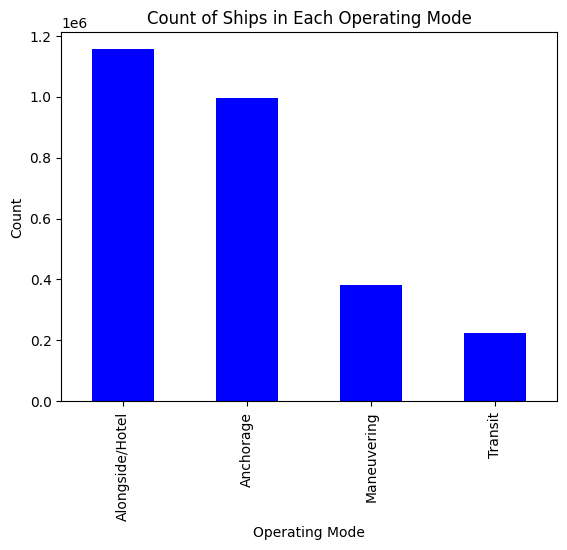

In [5]:
# Plot a bar graph
operating_mode_counts.plot(kind='bar', color='blue')

# Add labels and title
plt.xlabel('Operating Mode')
plt.ylabel('Count')
plt.title('Count of Ships in Each Operating Mode')

# Show the plot
plt.show()

##### Step 2: Log events at each timestamp

The event duration is the difference between two consecutive timestamps for each vessel i.e. same IMO number.

Note: If the difference between two AIS time stamps is more than 10,000 seconds, then the event is not continuous and should not undergo calculation for this greater than 24-hour period. Thereafter it should start afresh.

In [6]:
# Step 2: Log events at each timestamp

# Ensure 'timestamp' column is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate the time differences in seconds between consecutive timestamps for each IMO
df['time_diff'] = df.groupby('imo')['timestamp'].diff().dt.total_seconds()

# Disregard time differences that are greater than 10,000 seconds
df['event_duration'] = df['time_diff'].where(df['time_diff'] <= 10000, 0)

df[['timestamp','event_duration']].head(10)

,timestamp,event_duration
0,2023-09-17 00:01:42+00:00,0.0
1,2023-09-17 00:01:44+00:00,2.0
2,2023-09-17 00:07:43+00:00,359.0
3,2023-09-17 00:07:45+00:00,2.0
4,2023-09-17 00:10:42+00:00,177.0
5,2023-09-17 00:10:45+00:00,3.0
6,2023-09-17 00:16:37+00:00,352.0
7,2023-09-17 00:16:40+00:00,3.0
8,2023-09-17 00:22:42+00:00,362.0
9,2023-09-17 00:22:45+00:00,3.0


##### Step 3: Determine the vessel type

Determine if the vessel is an Ocean Going Vessel (OGV, of below types) or a different type.

1.  Bulk carrier - cargo vessel for the carriage of dry bulk cargo
2.  Container ship – cargo vessel for the carriage of containerized goods
3.  General cargo – cargo vessel for the carriage of various types of dry cargo
4.  LPG / Anhydrous ammonia tanker – cargo vessel for the bulk carriage of liquefied petroleum gas or ammonia
5.  Passenger / Cruise ship - vessels for the carriage of passengers.
6.  Product tanker – cargo vessel for the carriage of refined oil products carried in bulk
7.  Reefer ship - special form of cargo ship. It is used to transport goods that must remain refrigerated during the entire transport or where the cold chain must not be interrupted
8.  Ro-ro ship – cargo vessel for the carriage of wheeled cargo
9.  Chemical Tankers - cargo vessels for the carriage of Chemicals

NOTE: LNG Tankers are to be excluded

In [7]:
# Step 3: Determine the vessel type

# Define a function to determine the vessel type
def determine_vessel_type(group):
    # Define a list of Ocean Going Vessel types (excluding LNG Tankers)
    ogv_types = [
        'Bulk Carrier',
        'Container Ship',
        'General Cargo',
        'LPG Tanker',
        'Passenger/Cruise',
        'Product Tanker',
        'Reefer',
        'RoRo',
        'Chemical Tanker',
        'Auto Carrier'
    ]

    # Check if the vessel group is in the list of OGV types
    if group in ogv_types:
        return 'OGV'
    else:
        return None

# Apply the function to the 'group' column to create a new 'vessel_type' column
df['OGV'] = df['group'].apply(determine_vessel_type)

# Drop non-OGV Vessels
df = df.dropna(subset=['OGV'])
# Count the occurrences of each category
operating_mode_counts = df['operating_mode'].value_counts()
print(operating_mode_counts)
print("\n")
print(df['OGV'].value_counts())

Alongside/Hotel    773336
Anchorage          442634
Transit             64963
Maneuvering         63556
Name: operating_mode, dtype: int64


OGV    1344489
Name: OGV, dtype: int64


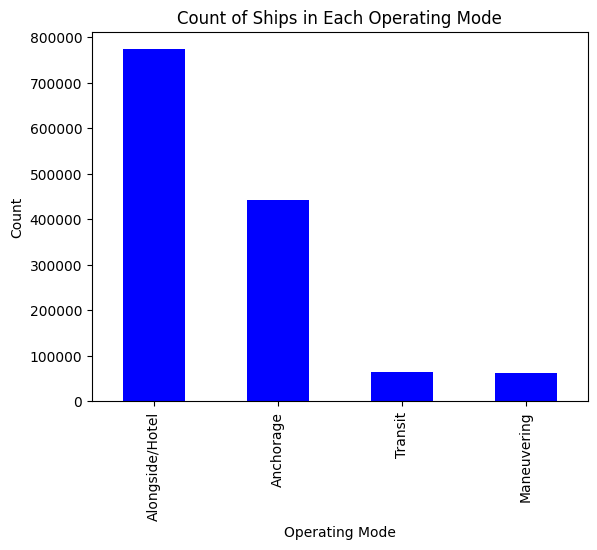

In [8]:
# Plot a bar graph
operating_mode_counts.plot(kind='bar', color='blue')

# Add labels and title
plt.xlabel('Operating Mode')
plt.ylabel('Count')
plt.title('Count of Ships in Each Operating Mode')

# Show the plot
plt.show()

##### Step 4: Determine Emissions Tier

For OGVs, identify its Emissions Tier using Model Year (derived from the vessel's build date).

In [9]:
# Step 4: Determine Emissions Tier using Model Year

# Ensure that 'date_of_build' is in datetime format
df['date_of_build'] = pd.to_datetime(df['date_of_build'])

# Extract the year from the build date
df['build_year'] = df['date_of_build'].dt.year

# Define a function to determine Emissions Tier based on build year and OGV status
def determine_emissions_tier(row):
    build_year = row['build_year']
    if build_year < 2000:
        return 0
    elif 2000 <= build_year <= 2010:
        return 1
    return 2

# Apply the function to each row in the DataFrame
df['emission_tier'] = df.apply(determine_emissions_tier, axis=1)
df[['emission_tier','build_year']].sample(10)

,emission_tier,build_year
2753948,1,2007
2717577,2,2020
1235531,2,2023
940871,1,2010
548578,2,2021
857921,1,2009
740819,1,2010
2782385,1,2004
293325,1,2008
992953,0,1998


##### Step 5: Determine Fuel Category

Ports have defined fuel categories (e.g. High Sulphur, Global 0.5%, ECA).

For 2023, Singapore will fall under Global 2020.

##### Step 6: Retrieve specific ship details for all vessels that are within the port boundary

1.  Main engine SFC (sfc\_me)
2.  Aux engine SFC (sfc\_ae)
3.  Auxiliary Boiler SFC (sfc\_ab)

##### Step 7: Calculate Emissions

This step is dependent on the previous steps. Refer to below explanation for emission calculations

Note:

*   Sequence to be strictly followed for calculations
*   Emissions do not need to be calculated for data points with missing parameters (e.g. p, speed, ael, abl, sfc\_me, sfc\_ae) and can be zero as default, where these parameters are used in calculation formulas.
*   If the missing parameters are not used in the calculation formula (e.g. for calculating emissions in alongside mode), there should be emissions.

###### Step 7a: Get the following parameters from the vessel movements data:

*   p
*   Reference speed (vref)
*   Actual speed (AS)

###### Step 7b: Calculate maximum speed

Formula:

> Maximum Speed (MS) = 1.066 x vref

In [10]:
# Step 7b: Calculate Maximum Speed (MS)
df['MS'] = 1.066 * df['vref']
df['MS'].sample(10)

142148     15.47832
10501      17.58900
2359039    15.56360
1839390    10.66000
248156     23.45200
2083053    23.45200
594659     23.45200
1483507    22.91900
193575     14.48694
1269956    21.10680
Name: MS, dtype: float64

In [11]:
df['MS'].describe()

count    1.337874e+06
mean     2.011319e+01
std      4.755856e+00
min      7.462000e+00
25%      1.545700e+01
50%      2.025400e+01
75%      2.398500e+01
max      3.731000e+01
Name: MS, dtype: float64

###### Step 7c: Get activity hours (A) for each operating mode

This was calculated in Step 2.

In [12]:
# Step 7c: Get activity hours (A) for each operating mode

# Ensure 'timestamp' column is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort the DataFrame by 'imo' and 'timestamp' to ensure we calculate durations correctly
df.sort_values(by=['imo', 'timestamp'], inplace=True)

# Calculate the time differences in seconds between consecutive timestamps for each IMO
df['time_diff'] = df.groupby('imo')['timestamp'].diff().dt.total_seconds()

# Disregard time differences that are greater than 10,000 seconds
df['event_duration'] = df['time_diff'].where(df['time_diff'] <= 10000, 0)

# Convert event_duration from seconds to hours
df['activity_hours'] = df['event_duration'] / 3600

# Group by 'imo' and 'operating_mode' to sum the activity hours for each operating mode per vessel
activity_hours_per_mode = df.groupby(['imo', 'operating_mode'])['activity_hours'].sum().reset_index()

# Now you have 'activity_hours' for each event. Events longer than 10,000 seconds have 0 hours.
# If you need to sum up the activity hours for each IMO or each operating mode, you can group by those fields.
# For example, to sum up by IMO:
activity_by_mode = df.groupby('operating_mode')['activity_hours'].sum().reset_index()

# Display the results
print(activity_by_mode)

    operating_mode  activity_hours
0  Alongside/Hotel    38962.499722
1        Anchorage    21076.903333
2      Maneuvering     3700.060278
3          Transit     8630.689444


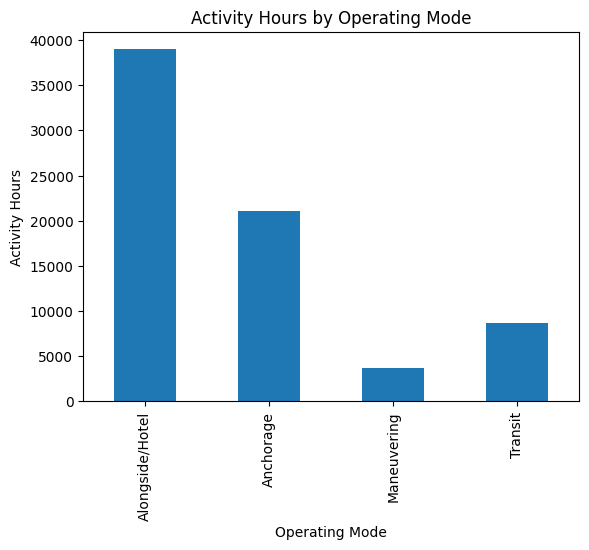

In [13]:
# Plot a bar chart
activity_by_mode.plot(kind='bar', x='operating_mode', y='activity_hours', legend=False)

# Add labels and title
plt.xlabel('Operating Mode')
plt.ylabel('Activity Hours')
plt.title('Activity Hours by Operating Mode')

# Show the plot
plt.show()

In [14]:
#Exploratory Data Analysis

# Group by 'imo' and sum the 'activity_hours' and count unique 'date_only' for each IMO
activity_by_mode = df.groupby('imo').agg({
    'activity_hours': 'sum',
    'date_only': 'nunique'  # This will count the unique dates for each IMO
}).reset_index()

# Rename the columns for clarity
activity_by_mode.rename(columns={'activity_hours': 'Total Activity Hours', 'date_only': 'Unique Days'}, inplace=True)

# Calculate the average activity hours across all IMOs
average_activity_hours = activity_by_mode['Total Activity Hours'].mean()
print(f"Average Activity Hours across all IMOs: {average_activity_hours}")

# Calculate the average number of unique days across all IMOs
average_unique_days = activity_by_mode['Unique Days'].mean()
print(f"Average Unique Days across all IMOs: {average_unique_days}")

Average Activity Hours across all IMOs: 40.005612370247526
Average Unique Days across all IMOs: 4.782200110558319


###### Step 7d (i): Calculate Engine Load Factor (LF) for propulsion engines

> LF\=(AS/MS)3LF =(AS/MS){^3}LF\=(AS/MS)3  
> Where  
> LF = Load Factor  
> AS = Actual speed (knots)  
> MS = Maximum speed (knots)

In [15]:
# Step 7d (i): Calculate Engine Load Factor (LF) for propulsion engines
df['LF'] = (df['speed'] / df['MS']) ** 3
df[df['LF'] != 0][['speed', 'MS', 'LF']].sample(10)

,speed,MS,LF
2654715,10.0,12.259,0.542794
738397,7.0,20.254,0.041282
1905769,22.0,26.650,0.562570
1529272,15.0,28.782,0.141550
331996,11.0,14.924,0.400426
1304168,19.0,19.188,0.970894
61948,16.0,29.848,0.154033
1134820,21.0,26.650,0.489290
2489524,12.0,27.716,0.081162
2687899,16.0,29.848,0.154033


###### Step 7d(ii): Look up Low Load Adjustment Factor (LLAF) using LF calculated in Step 7d(i)

*   Refer to llaf\_table
*   LLAF is not applicable if LF is more than 0.2. LLAF will be 1 in such cases.

**LLAF Table**

|   Load |   NOx |    HC |   CO |   PM |   SO2 |   CO2 |   N2O |   CH4 |
|-------:|------:|------:|-----:|-----:|------:|------:|------:|------:|
|   0.02 |  4.63 | 21.18 | 9.68 | 7.29 |  3.36 |  3.28 |  4.63 | 21.18 |
|   0.03 |  2.92 | 11.68 | 6.46 | 4.33 |  2.49 |  2.44 |  2.92 | 11.68 |
|   0.04 |  2.21 |  7.71 | 4.86 | 3.09 |  2.05 |  2.01 |  2.21 |  7.71 |
|   0.05 |  1.83 |  5.61 | 3.89 | 2.44 |  1.79 |  1.76 |  1.83 |  5.61 |
|   0.06 |  1.6  |  4.35 | 3.25 | 2.04 |  1.61 |  1.59 |  1.6  |  4.35 |
|   0.07 |  1.45 |  3.52 | 2.79 | 1.79 |  1.49 |  1.47 |  1.45 |  3.52 |
|   0.08 |  1.35 |  2.95 | 2.45 | 1.61 |  1.39 |  1.38 |  1.35 |  2.95 |
|   0.09 |  1.27 |  2.52 | 2.18 | 1.48 |  1.32 |  1.31 |  1.27 |  2.52 |
|   0.1  |  1.22 |  2.2  | 1.96 | 1.38 |  1.26 |  1.25 |  1.22 |  2.2  |
|   0.11 |  1.17 |  1.96 | 1.79 | 1.3  |  1.21 |  1.21 |  1.17 |  1.96 |
|   0.12 |  1.14 |  1.76 | 1.64 | 1.24 |  1.18 |  1.17 |  1.14 |  1.76 |
|   0.13 |  1.11 |  1.6  | 1.52 | 1.19 |  1.14 |  1.14 |  1.11 |  1.6  |
|   0.14 |  1.08 |  1.47 | 1.41 | 1.15 |  1.11 |  1.11 |  1.08 |  1.47 |
|   0.15 |  1.06 |  1.36 | 1.32 | 1.11 |  1.09 |  1.08 |  1.06 |  1.36 |
|   0.16 |  1.05 |  1.26 | 1.24 | 1.08 |  1.07 |  1.06 |  1.05 |  1.26 |
|   0.17 |  1.03 |  1.18 | 1.17 | 1.06 |  1.05 |  1.04 |  1.03 |  1.18 |
|   0.18 |  1.02 |  1.11 | 1.11 | 1.04 |  1.03 |  1.03 |  1.02 |  1.11 |
|   0.19 |  1.01 |  1.05 | 1.05 | 1.02 |  1.01 |  1.01 |  1.01 |  1.05 |
|   0.2  |  1    |  1    | 1    | 1    |  1    |  1    |  1    |  1    |

In [16]:
# Step 7d(ii): Look up Low Load Adjustment Factor (LLAF) using LF calculated in Step 7d(i)
# LLAF is not applicable if LF is more than 0.2. LLAF will be 1 in such cases.
subfolder_path = 'supplementary_tables/llaf_table.csv'
llaf = pd.read_csv(os.path.join(folder_path, subfolder_path))
llaf['Load'] = llaf['Load'].str.strip()
llaf['Load'] = llaf['Load'].str.rstrip('%').astype(float) / 100
print("\033[1m" + "LLAF Supplementary Table" + "\033[0m")
print(llaf)

# Round LF to 2 decimal places to match values in "Load" column of LLAF Table
def determine_rounded_LF(row):
    return round(row['LF'], 2)
df['rounded_LF'] = df.apply(determine_rounded_LF, axis=1)

# round "load" to 2 decimal place similarly due to bug (suspected due to internal rounding and float representations)
def determine_round(row):
    return round(row['Load'], 2)
llaf['rounded_load'] = llaf.apply(determine_round, axis=1)

# Look up LLAF using LF
merged_df = pd.merge(df, llaf, left_on='rounded_LF', right_on='rounded_load', how='left')
# Drop the specified columns
columns_to_drop = ['Load', 'rounded_load', 'NOx', 'HC', 'CO', 'PM', 'SO2', 'N2O', 'CH4']
merged_df.drop(columns=columns_to_drop, inplace=True)
merged_df.rename(columns={'CO2': 'LLAF'}, inplace=True)
df = merged_df
df.loc[df['rounded_LF'] > 0.2, 'LLAF'] = 1

# Check Merge
print("\n\033[1m" + "Check Proper Matching of Rounded LF to LLAF" + "\033[0m")
print(df[df['rounded_LF'] != 0][['rounded_LF','LLAF']].sample(10))

print("\n\033[1m" + "Check LLAF has been replaced by 1 if LF > 0.2" + "\033[0m")
print(df[df['rounded_LF'] > 0.2][['rounded_LF','LLAF']].sample(10))

LLAF Supplementary Table
    Load   NOx     HC    CO    PM   SO2   CO2   N2O    CH4
0   0.02  4.63  21.18  9.68  7.29  3.36  3.28  4.63  21.18
1   0.03  2.92  11.68  6.46  4.33  2.49  2.44  2.92  11.68
2   0.04  2.21   7.71  4.86  3.09  2.05  2.01  2.21   7.71
3   0.05  1.83   5.61  3.89  2.44  1.79  1.76  1.83   5.61
4   0.06  1.60   4.35  3.25  2.04  1.61  1.59  1.60   4.35
5   0.07  1.45   3.52  2.79  1.79  1.49  1.47  1.45   3.52
6   0.08  1.35   2.95  2.45  1.61  1.39  1.38  1.35   2.95
7   0.09  1.27   2.52  2.18  1.48  1.32  1.31  1.27   2.52
8   0.10  1.22   2.20  1.96  1.38  1.26  1.25  1.22   2.20
9   0.11  1.17   1.96  1.79  1.30  1.21  1.21  1.17   1.96
10  0.12  1.14   1.76  1.64  1.24  1.18  1.17  1.14   1.76
11  0.13  1.11   1.60  1.52  1.19  1.14  1.14  1.11   1.60
12  0.14  1.08   1.47  1.41  1.15  1.11  1.11  1.08   1.47
13  0.15  1.06   1.36  1.32  1.11  1.09  1.08  1.06   1.36
14  0.16  1.05   1.26  1.24  1.08  1.07  1.06  1.05   1.26
15  0.17  1.03   1.18  1.17  1.

###### Step 7e: If LF < 0.2 and mode is transit or maneuver, then LF will be defaulted to 0 .2.

Note: this default is not applied when identifying LLAF

###### Step 7f: Emission factor (EF) table is provided. Singapore is a non-Emission Controlled Area (ECA) so Global 2020 rows are applicable. The EF table has some formulas applied for certain pollutants:

  
1. NOx: *Omitted*
2.  PM10 will be calculated as follows:*Omitted*
3.  PM2.5 = *Omitted*
4.  VOC = *Omitted*
5.  SOx – *Omitted*
6.  CO2 - Refer to vessel movements table

*   For Main Engine= sfc\_me x 0.867 x 3.667
*   For Auxiliary engine= sfc\_ae x 0.867 x 3.667
*   For Auxiliary Boiler= sfc\_ab x 0.867 x 3.667

7.  CH4 - *Omitted*
8.  N2O – *Omitted*

In [17]:
# Step 7f: Calculate Emission Factors using formula provided (only CO2 calculated as per submission requirements)
df['main_engine_EF'] = df['sfc_me'] * 2 * 0.867 * 3.667
df['aux_engine_EF'] = df['sfc_ae'] * 2 * 0.867 * 3.667
df['aux_boiler_EF'] = df['sfc_ab'] * 2 * 0.867 * 3.667
df[['main_engine_EF','aux_engine_EF','aux_boiler_EF']].sample(10)

,main_engine_EF,aux_engine_EF,aux_boiler_EF
314264,1112.751150,1462.472940,1907.5734
741755,1241.830283,1552.764748,1907.5734
1295748,1112.751150,1398.887160,1907.5734
717246,1112.751150,1398.887160,1907.5734
1178520,1112.751150,1398.887160,1907.5734
699450,1112.751150,1462.472940,1907.5734
128414,1114.022866,1250.732293,1907.5734
29076,1239.922710,1462.472940,1907.5734
1148894,1239.922710,1462.472940,1907.5734
190143,1176.336930,1462.472940,1907.5734


###### Step 7g: Based on above identifications, the formulae below will be used to get the final results.

The emission factor is in terms of emissions per unit of energy from the engine. It is multiplied by the energy consumed while in each mode.  
  
Propulsion engine emissions for each mode are calculated according to the general equation:  
  

> E = P x LF x A x EF x LLAF  
>   
> Where  
> E = Emissions (grams \[g\])  
> P = Maximum Continuous Rating (MCR) Power for propulsion engines (kilowatts \[kW\])  
> LF = Load Factor (percent of vessel's total power)  
> A = Activity (hours \[h\]) (hours/call)  
> EF = Emission Factor (grams per kilowatt-hour \[g/kWh\])  
> LLAF = Low Load Adjustment Factor for when the load factor is below 20%.

Auxiliary engine emissions are calculated according to the general equation:  
  

> E = LA X A x EF  
>   
> Where  
> E = Emissions (grams \[g\])  
> LA​ = Auxiliary engine load (kW)  
> A = Activity (hours \[h\]) (hours/call)  
> EF = Emission Factor (grams per kilowatt-hour \[g/kWh\])  
>   

Auxiliary boiler emissions are calculated using the general equation below:  
  

> E = LB X A x EF  
>   
> Where  
> E = Emissions (grams \[g\])  
> LB​ = Boiler Load (kW),  
> A = Activity (hours \[h\]) (hours/call)  
> EF = Emission Factor (grams per kilowatt-hour \[g/kWh\])

###### Step 7h: In vessel movements data, identify the below:

LA​ = Auxiliary Engine load (Column ael)  
LB= Auxiliary Boiler load (Column abl)

In [18]:
# Columns involved in the emissions calculations
columns_for_emissions = ['p', 'LF', 'activity_hours', 'main_engine_EF', 'ael', 'abl']

# Drop rows with null values in these columns
df = df.dropna(subset=columns_for_emissions)

# Create a copy of the DataFrame to work with
df_copy = df.copy()

# Perform the operations on the copy
df_copy.loc[:, 'prop_emission'] = df_copy['p'] * df_copy['LF'] * df_copy['activity_hours'] * df_copy['main_engine_EF'] * df_copy['LLAF']
df_copy.loc[:, 'prop_emission'] = df_copy['prop_emission'].fillna(0)
df_copy.loc[:, 'aux_emission'] = df_copy['ael'] * df_copy['activity_hours'] * df_copy['aux_engine_EF']
df_copy.loc[:, 'boiler_emission'] = df_copy['abl'] * df_copy['activity_hours'] * df_copy['aux_boiler_EF']

df_copy.loc[:, 'total_co2_emissions'] = df_copy['prop_emission'] + df_copy['aux_emission'] + df_copy['boiler_emission']


In [19]:
# Print Results

total_co2_emissions = sum(df_copy['total_co2_emissions'])/1000/1000
print(f"Total CO2 Emissions: \t\t{total_co2_emissions}\n")

transit_co2_emissions = sum(df_copy[df_copy['operating_mode'] == 'Transit']['total_co2_emissions'])/1000/1000
print(f"Transit CO2 Emissions: \t\t{transit_co2_emissions}")

anchorage_co2_emissions = sum(df_copy[df_copy['operating_mode'] == 'Anchorage']['total_co2_emissions'])/1000/1000
print(f"Anchorage CO2 Emissions: \t{anchorage_co2_emissions}")

maneuvering_co2_emissions = sum(df_copy[df_copy['operating_mode'] == 'Maneuvering']['total_co2_emissions'])/1000/1000
print(f"Maneuvering CO2 Emissions: \t{maneuvering_co2_emissions}")

alongside_hotel_co2_emissions = sum(df_copy[df_copy['operating_mode'] == 'Alongside/Hotel']['total_co2_emissions'])/1000/1000
print(f"Alongside/Hotel CO2 Emissions: \t{alongside_hotel_co2_emissions}")

Total CO2 Emissions: 		357154.3305189985

Transit CO2 Emissions: 		127130.50405605523
Anchorage CO2 Emissions: 	29401.6514987372
Maneuvering CO2 Emissions: 	106190.78656677481
Alongside/Hotel CO2 Emissions: 	94431.38839724516


#### Total Electrical Load Analysis

Alongside or hotel load is the electrical load when the vessel is at the terminal/berth. In this mode the Main Engine is off since the Propulsion is not happening. Auxiliary Engines are running since they need to supply the electrical load for the ship and loading/discharging operating machineries.  
  
Auxiliary Boilers produce steam and hence cannot be plugged into the electrical grid and there is no machinery onboard to generate steam.  
  
Hence, for the purpose of this scope the Auxiliary engine load (column ael) in alongside mode will be used to identify the electrical load demand of the ships.  
  
Total electrical demand from ship in alongside mode (Tael) = time-weighted average electrical load (ael) in alongside mode = (Sum of Product of Ael multiplied by alongside duration hours) divide by (Sum of total alongside duration in hours).

In [20]:
# Create copy of df with only "Alongside/Hotel" data to conduct Electrical Load Analysis
df_alongside = df[df['operating_mode'] == 'Alongside/Hotel'][['imo','timestamp','activity_hours','ael']].copy()

In [21]:
# Define day and night hours
day_start, day_end = 9, 17  # 09:00 to 17:00 hours for Day

# Calculate end time of the event
df_alongside['end_timestamp'] = df_alongside['timestamp'] + pd.to_timedelta(df_alongside['activity_hours'], unit='h')

# Initialize new columns
df_alongside['day_activity_hours'] = 0
df_alongside['night_activity_hours'] = 0

# Iterate over rows to calculate day and night activity hours
for index, row in df_alongside.iterrows():
    start_hour = row['timestamp'].hour
    end_hour = row['end_timestamp'].hour
    duration = row['activity_hours']

    if (not day_start <= start_hour < day_end) and (not day_start <= end_hour < day_end):
        df_alongside.at[index, 'night_activity_hours'] += duration
        continue

    if day_start <= start_hour < day_end and day_start <= end_hour < day_end:
        df_alongside.at[index, 'day_activity_hours'] += duration
        continue

    # Case 1: Start time is earlier than 9 am but end time is later than 9 am
    if start_hour < day_start and day_start <= end_hour < day_end:
        night_duration = (df_alongside.at[index, 'timestamp'].replace(hour=day_start, minute=0, second=0) - df_alongside.at[index, 'timestamp']).total_seconds() / 3600
        day_duration = duration - night_duration
        df_alongside.at[index, 'night_activity_hours'] += night_duration
        df_alongside.at[index, 'day_activity_hours'] += day_duration

    # Case 2: Start time is earlier than 17:00 but end time is later than 17:00
    if day_start <= start_hour < day_end and end_hour >= day_end:
        day_duration = (df_alongside.at[index, 'end_timestamp'].replace(hour=day_end, minute=0, second=0) - df_alongside.at[index, 'timestamp']).total_seconds() / 3600
        night_duration = duration - day_duration
        df_alongside.at[index, 'day_activity_hours'] += day_duration
        df_alongside.at[index, 'night_activity_hours'] += night_duration

# Check overlaps have been calculated correctly
filtered_df = df_alongside[(df_alongside['day_activity_hours'] != 0) & (df_alongside['night_activity_hours'] != 0)]
filtered_df.sample(10)

,imo,timestamp,activity_hours,ael,end_timestamp,day_activity_hours,night_activity_hours
663421,9484431,2023-08-26 08:57:26+00:00,0.100278,1396.0,2023-08-26 09:03:27.000000800+00:00,0.057500,0.042778
113109,9182631,2023-08-06 08:59:15+00:00,0.149444,834.0,2023-08-06 09:08:12.999998400+00:00,0.136944,0.012500
970291,9732321,2023-09-24 08:58:31+00:00,0.099444,1330.0,2023-09-24 09:04:28.999998400+00:00,0.074722,0.024722
646227,9470894,2023-08-24 08:56:51+00:00,0.100000,801.0,2023-08-24 09:02:51+00:00,0.047500,0.052500
27381,9085596,2023-08-14 08:56:52+00:00,0.100278,775.0,2023-08-14 09:02:53.000000800+00:00,0.048056,0.052222
294757,9302152,2023-09-27 16:56:39+00:00,0.100833,1128.0,2023-09-27 17:02:41.999998800+00:00,0.056111,0.044722
425868,9352042,2023-08-09 16:57:54+00:00,0.100278,1164.0,2023-08-09 17:03:55.000000800+00:00,0.035000,0.065278
184796,9234109,2023-09-27 08:57:17+00:00,0.098889,869.0,2023-09-27 09:03:13.000000400+00:00,0.053611,0.045278
1248116,9885142,2023-08-20 08:57:04+00:00,0.098889,842.0,2023-08-20 09:03:00.000000400+00:00,0.050000,0.048889
1207857,9869174,2023-09-12 08:56:21+00:00,0.099444,1376.0,2023-09-12 09:02:18.999998400+00:00,0.038611,0.060833


In [22]:
# Create new 'day_EL' and 'night_EL' column with ael value if duration overlaps the specified timings
df_alongside['day_EL'] = df_alongside[df_alongside['day_activity_hours'] != 0]['ael']
df_alongside['night_EL'] = df_alongside[df_alongside['night_activity_hours'] != 0]['ael']

# Display the results
print("Total Day EL:\t", df_alongside['day_EL'].sum())
print("Total Night EL:\t", df_alongside['night_EL'].sum())
print("Total EL:\t", df_alongside['ael'].sum())

Total Day EL:	 268016912.0
Total Night EL:	 546013869.0
Total EL:	 811801723.0


#### Load demand variation from the grid through day and night on a monthly basis

1.  For each “Alongside” operation mode, identify the time of the day as per below definition of Day and Night from timestamp column in vessel movements table.

*   Day = 0900 to 1700 hours
*   Night = 1700 to 0900 hours

2.  Create visualizations to analyze the trends of the daily and monthly demand on the shore supply grid.
3.  For DayEL and NightEL results, use the formula provided in previous section for the associated time description stated above.  
      
    NOTE: This day/ night demand can vary significantly depending on the weather and time of year in many parts of the world if not so much in Singapore. Example, winter may lead to smaller daylight time and hence more demand for vessel’s external lights to be on and vice versa.

In [23]:
# Multiply 'ael' with 'day_activity_hours' and 'night_activity_hours'
df_alongside['electrical_demand_day'] = df_alongside['ael'] * df_alongside['day_activity_hours']
df_alongside['electrical_demand_night'] = df_alongside['ael'] * df_alongside['night_activity_hours']

# Group by 'imo' and sum the total AEL for day and night
grouped_ael = df_alongside.groupby('imo').agg({
    'electrical_demand_day': 'sum',
    'electrical_demand_night': 'sum'
}).reset_index()

# Display the resulting DataFrame
print(grouped_ael)

          imo  electrical_demand_day  electrical_demand_night
0     8413409            4509.102500             13649.807500
1     8420907           43434.935278             89064.679167
2     8813659            5709.159444              8017.670556
3     8952857             443.022222              7880.579167
4     9046423            6335.237777             21196.271112
...       ...                    ...                      ...
1113  9967483               0.000000              4326.373333
1114  9970428           62465.544165            119749.565835
1115  9970430            8947.378611             23666.591667
1116  9970442           57549.650277            118658.582778
1117  9970454           42149.778610             82523.445278

[1118 rows x 3 columns]


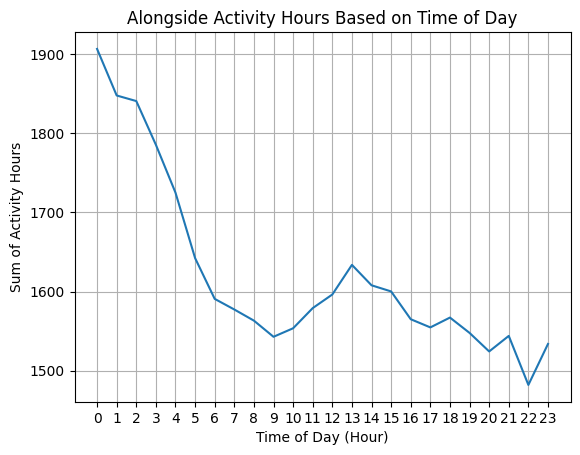

In [24]:
# Extract hour from Timestamp
df_alongside['Hour'] = df_alongside['timestamp'].dt.hour

# Group by hour and calculate average activity hours
activity_by_hour = df_alongside.groupby('Hour')['activity_hours'].sum().reset_index()

# Plot the graph
plt.plot(activity_by_hour['Hour'], activity_by_hour['activity_hours'])
plt.xlabel('Time of Day (Hour)')
plt.ylabel('Sum of Activity Hours')
plt.title('Alongside Activity Hours Based on Time of Day')
plt.grid(True)
plt.xticks(range(0, 24, 1))  # Set x-axis ticks to show every hour
plt.show()

Day
count      1118.000000
mean      11838.667475
std       11265.591435
min           0.000000
25%        5460.191528
50%        9581.841667
75%       15342.427638
max      141745.481666
Name: electrical_demand_day, dtype: float64

Night
count      1118.000000
mean      24469.407250
std       22001.835556
min           0.000000
25%       10834.995417
50%       19303.690834
75%       31912.214584
max      280545.321667
Name: electrical_demand_night, dtype: float64


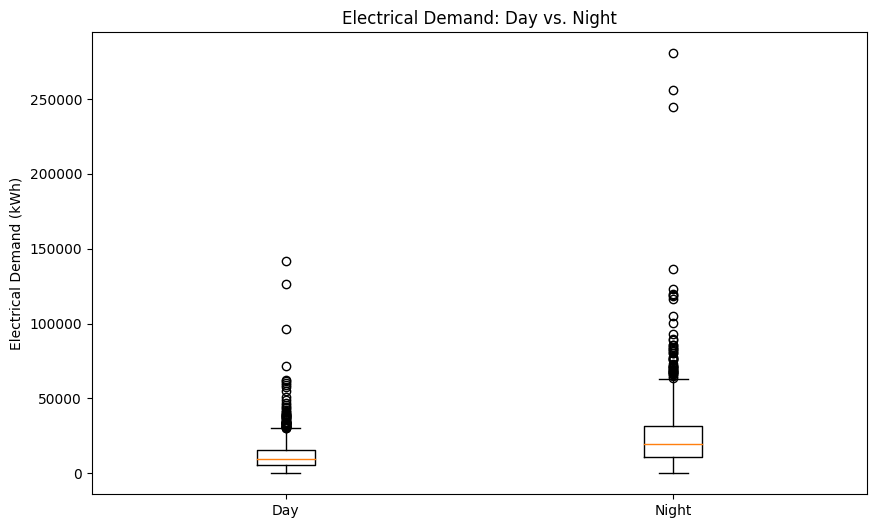

In [25]:
# Creating box plots
plt.figure(figsize=(10, 6))
plt.boxplot([grouped_ael['electrical_demand_day'], grouped_ael['electrical_demand_night']], labels=['Day', 'Night'])
plt.title('Electrical Demand: Day vs. Night')
plt.ylabel('Electrical Demand (kWh)')

print("\033[1m" + "Day" + "\033[0m")
print(grouped_ael['electrical_demand_day'].describe())
print("\n\033[1m" + "Night" + "\033[0m")
print(grouped_ael['electrical_demand_night'].describe())

# Show the plot
plt.show()